In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint

/home/jongho/바탕화면/project/venv3.8_ViT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_dir = Path("./data/asl_alphabet_train/asl_alphabet_train")

In [5]:
ds=ImageFolder(data_dir)
indices = torch. randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

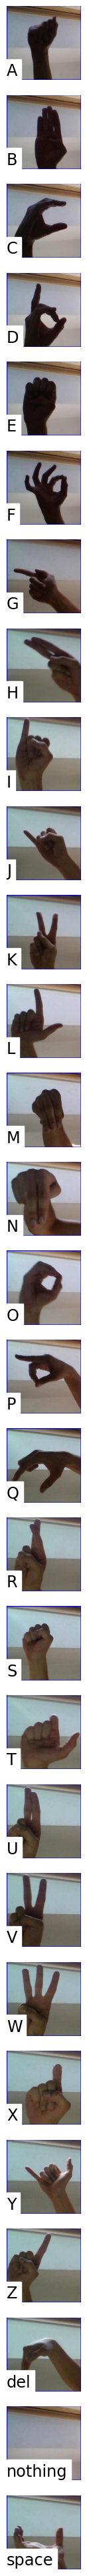

In [6]:
plt.figure(figsize=(100,50))
num_examples_per_class = 1
i = 1
for class_idx, class_name in enumerate(ds.classes):
  folder = ds.root / class_name
  for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
    if image_path.suffix in ds.extensions:
      image = Image.open(image_path)
      plt.subplot(len(ds.classes), num_examples_per_class, i)
      ax = plt.gca()
      ax.set_title(
         class_name,
         size='xx-large',
         pad=5,
         loc='left',
         y=0,
         backgroundcolor='white'
      )
      ax.axis('off')
      plt.imshow(image)
      i += 1
      if image_idx + 1 == num_examples_per_class:
         break

In [7]:
label2id = {}
id2label = {}
for i, class_name in enumerate(ds.classes):
  label2id[class_name] = str(i)
  id2label[str(i)] = class_name

In [8]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=32, 
   collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, 
   num_workers=2)
model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)

/home/jongho/바탕화면/project/venv3.8_ViT/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class Classifier(pl.LightningModule):
   def __init__(self, model, lr: float = 2e-5, **kwargs): 
       super().__init__()
       self.save_hyperparameters('lr', *list(kwargs))
       self.model = model
       self.forward = self.model.forward 
       self.val_acc = Accuracy()
   def training_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"train_loss", outputs.loss)
       return outputs.loss
   def validation_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"val_loss", outputs.loss)
       acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"val_acc", acc, prog_bar=True)
       return outputs.loss
   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), 
                        lr=self.hparams.lr,weight_decay = 0.00025)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(precision=16, max_epochs=3)
trainer.fit(classifier, train_loader, val_loader)
